In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import codecs
import re
import time
import os


In [3]:
# Укажем путь к папке
directory_path = "C:\\Users\\Алексей\\Go Russia2"
output_file_path = "C:\\Users\\Алексей\\Go Russia2\\1\\output_file_path.html"

# Открываем выходной файл для записи
with codecs.open(output_file_path, 'w', 'utf-8') as output_file:
    # Проходим по всем файлам в директории
    for filename in os.listdir(directory_path):
        # Проверяем, что файл имеет расширение .html
        if filename.endswith('.html'):
            file_path = os.path.join(directory_path, filename)  # Получаем полный путь к файлу
            #with codecs.open(file_path, 'r', 'utf-8') as f:
            r=codecs.open(file_path, 'r', 'utf-8')# Читаем файл
                # Записываем содержимое файла в выходной файл
            output_file.write(r.read() + '\n')  # Добавляем перевод строки между файлами


In [5]:
with open("C:\\Users\\Алексей\\Go Russia2\\1\\output_file_path.html", 'r', encoding='utf-8') as f:
    check_html = f.read()
# Здесь мы пользумся регуляркой, чтобы убрать лишние закрывающие теги </body>, которые раздробрили бы наш общий текст на разные <body>.
res = re.sub(r' </body>\s.*\s.*\s.*\s.*\s.*\s.*\s.*\s.*\s.*\s.*\s.*\s.*\s.*\s.*\s.*\s.*\s.*\s.*\s.*\s.*\s.<body onload=\"CheckLocation\(\);\">', '', check_html)

soup = BeautifulSoup(res)
#soup

In [7]:
# Создаем список для хранения данных
data = []

# Извлекаем сообщения
messages = soup.find_all('div', class_='message default clearfix')

for message in messages:
    # Заголовок поста
    title_tag = message.find('strong')
    title = title_tag.get_text(strip=True) if title_tag else ''
    
    # Текст поста
    text_tag = message.find('div', class_='text')
    if text_tag:
        # Удаляем заголовок из текста и сохраняем пробелы
        # Получаем текст, используя метод get_text() с разделителем
        text = text_tag.get_text(separator=' ', strip=True).replace(title, '').strip()
        text = re.sub(r'#[А-Яа-яёй]+', '', text)  # Убираем хештеги
        text = re.sub(r'По России • Travel Blog', '', text)  # Удаляем фразу
        text = re.sub(r'Координаты[:\s*Яндекс.Карты..[А-Яа-я]*.[А-Яа-я]*]*', '', text)  # Удаляем фразу
        text = re.sub(r'Локация\s*[накарте]*.', '', text)  # Удаляем фразу
        text = re.sub(r'[(М|м)есто на]*карте', ' ', text)  # Удаляем фразу
        text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ .!?-]', '', text)  # Удаляем лишние символы
        text = re.sub(r'\s-\s', '', text)  # Удаляем лишние символы
        text = re.sub(r'\s+', ' ', text).strip()  # Удаляем лишние пробелы
    else:
        text = ''
       
    # Отфильтровываем лишние пробелы
    text = ' '.join(text.split())
    
    # Дата публикации
    date_tag = message.find('div', class_='pull_right date details')
    date = date_tag['title'] if date_tag else ''

    # Извлекаем ссылку на локацию
    location_link = message.find('a', string='карте')
    location_url = location_link['href'] if location_link else ''
    
    # Количество просмотров (эмодзи)
    reactions = message.find_all('div', class_='reaction')
    emoji_counts = {reaction.find('div', class_='emoji').get_text(strip=True): int(reaction.find('div', class_='count').get_text(strip=True)) for reaction in reactions}
      
    # Извлекаем #
    hashtag_tags = message.find_all('a', href=True, onclick=True)
#print (hashtag_tags)
    hashtag_word = [tag.get_text(strip=True) for tag in hashtag_tags]
    hashtags = ', '.join(hashtag_word)
    hashtags = re.sub('[^a-zA-Zа-яА-ЯёЁ#.!?-]', '', hashtags).lower()
    # Собираем данные в словарь
    data.append({
        'Заголовок': title,
        'Текст': text,
        'Дата публикации': date,
        'Эмодзи': emoji_counts,
        'Локация на карте': location_url,
        'Название региона': hashtags
    })

# Создаем DataFrame
df = pd.DataFrame(data)

# Выводим DataFrame
df

,Заголовок,Текст,Дата публикации,Эмодзи,Локация на карте,Название региона
0,Работа на Юге. ТОП-15 Вакансий,Строительная сфера на юге развивается семимиль...,23.07.2023 10:13:35 UTC+04:00,"{'👍': 23, '❤': 1, '👏': 1, '😁': 1}",,
1,Куда дети перевозят своих родителей? Где прове...,Климат морской полезен для всех. Очень часто м...,24.07.2023 11:45:50 UTC+04:00,"{'👍': 23, '🐳': 3}",,
2,"Головой на море, ""одним местом"" на диване.",Если вы в эти дни не на морене расстраивайтесь...,25.07.2023 12:48:20 UTC+04:00,"{'👍': 11, '❤': 2, '🤔': 1}",,
3,Лучший город России. Рейтинг,Ты все ещё ищешь лучший город России? Блогер-у...,26.07.2023 14:52:33 UTC+04:00,"{'👍': 53, '👎': 13, '❤': 5}",,
4,Жить у моря полезно.,Я тут наткнулся на статью про воду там ученые ...,27.07.2023 10:55:21 UTC+04:00,"{'👍': 17, '❤': 2, '🔥': 1}",,
...,...,...,...,...,...,...
2965,"Грот Голицына (Шаляпина) в Новом Свете, Респуб...",Эта пещера появилась естественным образом и бы...,13.08.2024 09:26:01 UTC+04:00,"{'❤': 142, '👍': 103, '🔥': 23, '😍': 9, '🤩': 4, ...",https://yandex.ru/maps/org/grot_golitsyna/1814...,#республикакрым
2966,«Сулекская писаница» в Хакасии,Это настоящий памятник изобразительного искусс...,13.08.2024 13:11:56 UTC+04:00,"{'❤': 76, '👍': 70, '🔥': 22, '👀': 4, '❤‍🔥': 1}",https://yandex.ru/maps?whatshere%5Bpoint%5D=89...,#республикахакасия
2967,Красота Триозёрья: вид сверху,Август время когда пляжи Приморья переполнены ...,13.08.2024 16:22:15 UTC+04:00,"{'😍': 78, '👍': 77, '❤‍🔥': 28, '🔥': 14, '❤': 13}",https://yandex.ru/maps/org/triozerye/118331101...,#приморскийкрай
2968,Памятный рисунок на месте предполагаемои‌ гибе...,В Кармадонском ущелье Северная Осетия установл...,13.08.2024 20:23:13 UTC+04:00,"{'❤': 180, '🙏': 166, '😢': 60, '👍': 38, '🕊': 38...",https://yandex.ru/maps?whatshere%5Bpoint%5D=44...,#республикасевернаяосетия


In [45]:
df. head(250)

,Заголовок,Текст,Дата публикации,Эмодзи,Локация на карте,Название региона
0,Работа на Юге. ТОП-15 Вакансий,Строительная сфера на юге развивается семимиль...,23.07.2023 10:13:35 UTC+04:00,"{'👍': 23, '❤': 1, '👏': 1, '😁': 1}",,
1,Куда дети перевозят своих родителей? Где прове...,Климат морской полезен для всех. Очень часто м...,24.07.2023 11:45:50 UTC+04:00,"{'👍': 23, '🐳': 3}",,
2,"Головой на море, ""одним местом"" на диване.",Если вы в эти дни не на морене расстраивайтесь...,25.07.2023 12:48:20 UTC+04:00,"{'👍': 11, '❤': 2, '🤔': 1}",,
3,Лучший город России. Рейтинг,Ты все ещё ищешь лучший город России? Блогер-у...,26.07.2023 14:52:33 UTC+04:00,"{'👍': 53, '👎': 13, '❤': 5}",,
4,Жить у моря полезно.,Я тут наткнулся на статью про воду там ученые ...,27.07.2023 10:55:21 UTC+04:00,"{'👍': 17, '❤': 2, '🔥': 1}",,
...,...,...,...,...,...,...
245,"Уксинская озовая гряда – чудо природы, оставше...",Это одно из самых красивых мест Карелии ! Ледн...,26.09.2023 17:36:07 UTC+04:00,"{'❤': 268, '👍': 182, '🔥': 38, '🤩': 9, '😁': 3, ...",https://yandex.ru/maps?whatshere%5Bpoint%5D=31...,#республикакарелия
246,Необычные Сырные скалы в Карачаево-Черкессии.,В Карачаево-Черкесии есть одно необычное место...,26.09.2023 19:18:01 UTC+04:00,"{'🔥': 260, '👍': 170, '❤': 42, '❤‍🔥': 11, '🤔': ...",https://yandex.ru/maps/org/syrnaya_peshchera/1...,#карачаевочеркесия
247,Усадьба Нероново – погибающее имперское наследие.,Усадьба Нероново относится к числу наиболее ин...,26.09.2023 22:07:06 UTC+04:00,"{'❤': 249, '😢': 204, '👍': 91, '🔥': 30, '😱': 10...",https://yandex.ru/maps/org/usadba_neronovo/202...,#костромскаяобласть
248,"Особняк Василия Каншина, содержателя питейных ...",Василий Семёнович Каншин был богатейшим челове...,27.09.2023 09:07:01 UTC+04:00,"{'👍': 320, '❤‍🔥': 52, '❤': 32, '🔥': 23, '👌': 2}",https://yandex.ru/maps?whatshere%5Bpoint%5D=30...,#санктпетербург


In [235]:
df.iloc[1000:1001]

,Заголовок,Текст,Дата публикации,Эмодзи,Локация на карте,Название региона
1000,На Театральной площади в Луганске зажгли огни ...,Музыка наполненная детским смехом заполнила пл...,2024-12-22 22:03:01+04:00,"{'❤': 175, '🔥': 76, '👍': 46, '🙏': 25, '🕊': 17,...",https://yandex.ru/maps?whatshere%5Bpoint%5D=39...,#луганскаянароднаяреспублика


In [237]:
#df.tail(10)

,Заголовок,Текст,Дата публикации,Эмодзи,Локация на карте,Название региона
2960,Золотые Ворота Коктебеля,В прибрежной части горного массива под названи...,2024-08-12 09:28:01+04:00,"{'👍': 163, '❤': 43, '😍': 31, '🔥': 18, '🤩': 5, ...",https://yandex.ru/maps/org/zolotyye_vorota/371...,#республикакрым
2961,,Камень-останец Чертов палец Чёртов палец это с...,2024-08-12 13:16:59+04:00,"{'👍': 113, '❤': 45, '🔥': 17, '❤‍🔥': 7, '🤩': 2,...",https://yandex.ru/maps/org/gora_chyortov_palet...,#самарскаяобласть
2962,Потрясающий пляж недалеко от Балаклавы - Затер...,Добраться сюда можно только по морю на каяке я...,2024-08-12 16:27:46+04:00,"{'❤': 142, '🔥': 68, '👍': 43, '🤩': 15, '❤‍🔥': 9...",https://yandex.ru/maps?whatshere%5Bpoint%5D=33...,#республикакрым
2963,Бурная жизнь на ост. Путятина,Это один из самых посещаемых островов залива П...,2024-08-12 19:24:01+04:00,"{'❤': 144, '👍': 69, '😍': 28, '🔥': 15, '🤗': 8, ...",https://yandex.ru/maps?whatshere%5Bpoint%5D=13...,#приморскийкрай
2964,Яркое северное сияние наблюдали минувшим вечер...,области Самые яркие световые всполохи разлилис...,2024-08-12 21:03:32+04:00,"{'❤': 203, '👍': 62, '🤩': 37, '🔥': 23, '👀': 18,...",,#ленинградскаяобласть
2965,"Грот Голицына (Шаляпина) в Новом Свете, Респуб...",Эта пещера появилась естественным образом и бы...,2024-08-13 09:26:01+04:00,"{'❤': 142, '👍': 103, '🔥': 23, '😍': 9, '🤩': 4, ...",https://yandex.ru/maps/org/grot_golitsyna/1814...,#республикакрым
2966,«Сулекская писаница» в Хакасии,Это настоящий памятник изобразительного искусс...,2024-08-13 13:11:56+04:00,"{'❤': 76, '👍': 70, '🔥': 22, '👀': 4, '❤‍🔥': 1}",https://yandex.ru/maps?whatshere%5Bpoint%5D=89...,#республикахакасия
2967,Красота Триозёрья: вид сверху,Август время когда пляжи Приморья переполнены ...,2024-08-13 16:22:15+04:00,"{'😍': 78, '👍': 77, '❤‍🔥': 28, '🔥': 14, '❤': 13}",https://yandex.ru/maps/org/triozerye/118331101...,#приморскийкрай
2968,Памятный рисунок на месте предполагаемои‌ гибе...,В Кармадонском ущелье Северная Осетия установл...,2024-08-13 20:23:13+04:00,"{'❤': 180, '🙏': 166, '😢': 60, '👍': 38, '🕊': 38...",https://yandex.ru/maps?whatshere%5Bpoint%5D=44...,#республикасевернаяосетия
2969,"Водопад ""Ступени мудрости"", урочище реки Курджипс",Каскадныи является самым доступным и посещаемы...,2024-08-13 22:03:03+04:00,"{'👍': 165, '🔥': 53, '❤‍🔥': 33, '❤': 16, '😍': 7}",https://yandex.ru/maps?whatshere%5Bpoint%5D=40...,#республикаадыгея


In [9]:
# Объединяем все названия регионов в один общий текст
all_hashtags = df['Название региона'].str.cat(sep=' ')  # sep=' ' добавляет пробел между текстами

# Сохраняем общий текст в файл
with open('Список регионов.txt', 'w', encoding='utf-8') as f:
    f.write(all_hashtags)

# Общий список регионов
print(all_hashtags[:1000])

              #мурманскаяобласть #крым   #приморскийкрай #дагестан    #сахалинскаяобласть           #республикаадыгея   #владимирскаяобласть  #республикакарелия #крым #приморскийкрай #красноярскийкрай #челябинскаяобласть #краснодарскийкрай  #республикакоми #калмыкия #кировскаяобласть  #пермскийкрай #тульскаяобласть  #приморскийкрай #мурманскаяобласть #приморскийкрай  #сахалин #приморскийкрай #республикакрым #алтай #ивановскаяобласть  #свердловскаяобласть #санктпетербург #приморскийкрай #самарскаяобласть #сахалинскаяобласть #калининградскаяобласть  #чукотскийавтономныйокруг #архангельскаяобласть #карачаевочеркесскаяреспублика #калининградскаяобласть #новгородскаяобласть #ленинградскаяобласть #мурманскаяобласть #республикадагестан #карачаевочеркесия  #республикаадыгея #карачаевочеркесия #карачаевочеркесия #забайкальскийкрай  #кабардинобалкария #сахалинскаяобласть  #республикакрым  #камчатскийкрай #кабардинобалкария  #ставропольскийкрай #воронежскаяобласть  #краснодарскийкрай  #республика

In [11]:
cleaned_text_all_hashtags = re.sub('#', ' ', all_hashtags)
#cleaned_text_all_hashtags = re.sub(',', ' ', cleaned_text_all_hashtags)  
cleaned_text_all_hashtags = re.sub(r'\s+', ' ', cleaned_text_all_hashtags).strip() # Удаляем лишние пробелы
print(cleaned_text_all_hashtags[:1000])

мурманскаяобласть крым приморскийкрай дагестан сахалинскаяобласть республикаадыгея владимирскаяобласть республикакарелия крым приморскийкрай красноярскийкрай челябинскаяобласть краснодарскийкрай республикакоми калмыкия кировскаяобласть пермскийкрай тульскаяобласть приморскийкрай мурманскаяобласть приморскийкрай сахалин приморскийкрай республикакрым алтай ивановскаяобласть свердловскаяобласть санктпетербург приморскийкрай самарскаяобласть сахалинскаяобласть калининградскаяобласть чукотскийавтономныйокруг архангельскаяобласть карачаевочеркесскаяреспублика калининградскаяобласть новгородскаяобласть ленинградскаяобласть мурманскаяобласть республикадагестан карачаевочеркесия республикаадыгея карачаевочеркесия карачаевочеркесия забайкальскийкрай кабардинобалкария сахалинскаяобласть республикакрым камчатскийкрай кабардинобалкария ставропольскийкрай воронежскаяобласть краснодарскийкрай республикаалтай пермскийкрай казань алтай кубанскоеводохранилиже забайкальскийкрай рязанскаяобласть республик

In [49]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk import word_tokenize
from nltk.probability import FreqDist

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Алексей\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Алексей\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Алексей\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


<Axes: title={'center': '20 самых частотных названий регионов'}, xlabel='Samples', ylabel='Counts'>

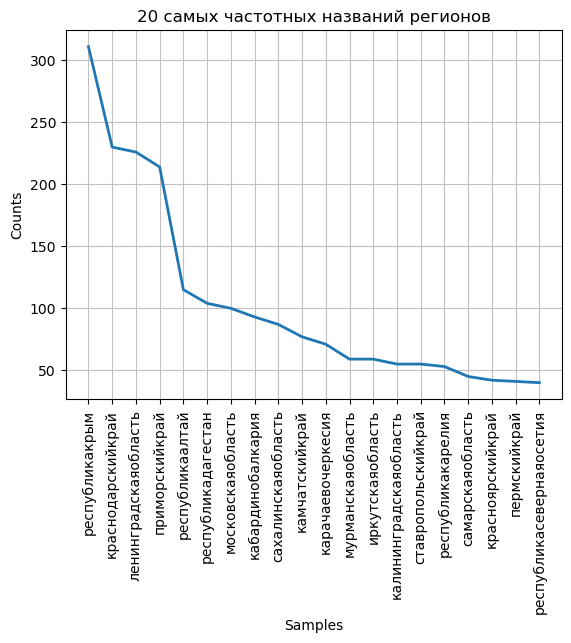

In [57]:
text_tokens_hashtags = word_tokenize(cleaned_text_all_hashtags)
word_frequencies = FreqDist(text_tokens_hashtags)
#print(dict(sorted(word_frequencies.items(), key=lambda item: item[1], reverse=True)))
word_frequencies.plot(20, title='20 самых частотных названий регионов')

In [13]:
# Объединяем все тексты про Республику Крым
crim_posts = df[df['Название региона'].str.contains('#республикакрым', na=False)]

# Объединяем все тексты из отфильтрованных строк в одну строку
combined_text = ' '.join(crim_posts['Текст'].tolist())

# Сохраняем объединенный текст в файл
with open('Тексты_РеспубликаКрым.txt', 'w', encoding='utf-8') as f:
    f.write(combined_text)

In [15]:
path = 'Тексты_РеспубликаКрым.txt'
with open(path, encoding='utf-8') as txt:
    crim_text = txt.read()
#print(text)
crim_text = re.sub('[^a-zA-Zа-яА-ЯёЁ -]', '', crim_text.lower()) # Удаляем лишние символы
crim_text = re.sub(r'\s+', ' ', crim_text).strip() # Удаляем лишние пробелы
print(crim_text[:1000])

интересный факт церковь воскресения христова называют одним из чудес крымского полуострова и для этого есть все основания в конце века земли фороса принадлежали чайному магнату александру кузнецову он не жалел ни времени ни средств для обустройства этого приморского поселка и по сей день он является одним из красивейших всего южного берега но кроме особняка и роскошного парка кузнецов решил построить храм он выбрал очень необычное место для его возведения отвесная скала красная высотой четыреста двенадцать метров над уровнем моря прекрасно подошла для строительства пустыня чарские пески рыбацкая деревня лавандовое поле тургеневка белые скалы остров итуруп музей-заповедник кижи республикакарелия мыс гамова приморскийкрай чокракское озеро каменные грибы в долине чулышман вулкан толбачик пляж баунти расположен в живописной бухте окружённой скалистыми преградами и обрывами кристально чистая вода здесь ярко-лазурного цвета благодаря светлому песку на дне от которого отражается свет солнца а

In [17]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk import word_tokenize

from nltk.corpus import stopwords

from pymorphy3 import MorphAnalyzer #загрузим анализатор
morph = MorphAnalyzer()

from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Алексей\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Алексей\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Алексей\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [18]:
lemm_tokens = []
for token in word_tokenize(crim_text):
    token_lemma = morph.parse(token)[0].normal_form
    lemm_tokens.append(token_lemma)
lemm_text_crim = ' '.join(lemm_tokens)
#print(len(set(lemm_tokens)))
#print(lemm_text_crim)

In [21]:
stopwords_ru = stopwords.words('russian')
stopwords = stopwords_ru + ['который', 'самый', 'каждый', 'свой','первый','такой','этот','сам','её','ваш','наш','весь']
tokens = lemm_text_crim.split()
crim_text_no_stop = ' '.join([token for token in tokens if token not in stopwords])
#print (crim_text_no_stop)
# Лемматизация и сбор существительных
list_of_nouns = [] 
for token in crim_text_no_stop.split(): #будем проверять каждое слово отдельно по очереди
    word_parsed = morph.parse(token)[0]
    if word_parsed.tag.POS == 'NOUN': #проверяем существительные
        list_of_nouns.append(word_parsed.normal_form) #сохраняем их в отдельный список
only_nouns = ' '.join(list_of_nouns) #создаём из списка строку
#only_nouns

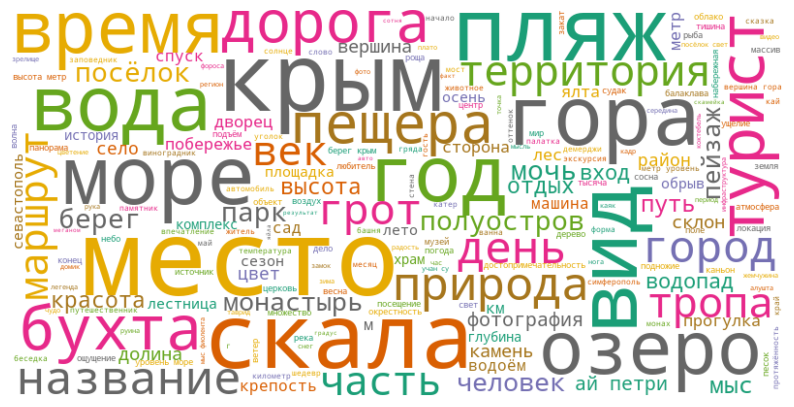

In [23]:
wordcloud = WordCloud(background_color='white', colormap = 'Dark2', width=800, height=400, random_state=21, max_font_size=110).generate(only_nouns)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

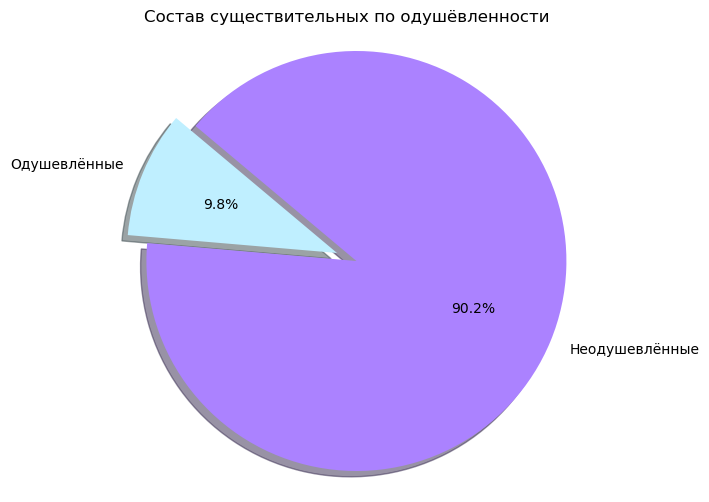

In [49]:
animate_nouns1 = 0  # Одушевленные
inanimate_nouns1 = 0  # Неодушевленные

# Проверяем каждое слово
for token in crim_text_no_stop.split():
    word_parsed1 = morph.parse(token)[0]
    if word_parsed1.tag.POS == 'NOUN':  # Проверяем существительные
        if word_parsed1.tag.animacy == 'anim':  # Одушевленные
            animate_nouns1 += 1
        elif word_parsed1.tag.animacy == 'inan':  # Неодушевленные
            inanimate_nouns1 += 1

# Данные для диаграммы
labels = ['Одушевлённые', 'Неодушевлённые']
sizes = [animate_nouns1, inanimate_nouns1]
colors = ['#BFEFFF','#AB82FF']
explode = (0.1, 0)  # "выделение" первого сегмента

# Создание круговой диаграммы
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Убедиться, что круг не будет эллипсом
plt.title('Состав существительных по одушёвленности')
plt.show()

In [51]:
animate_nouns1


547

In [53]:
inanimate_nouns1

5062

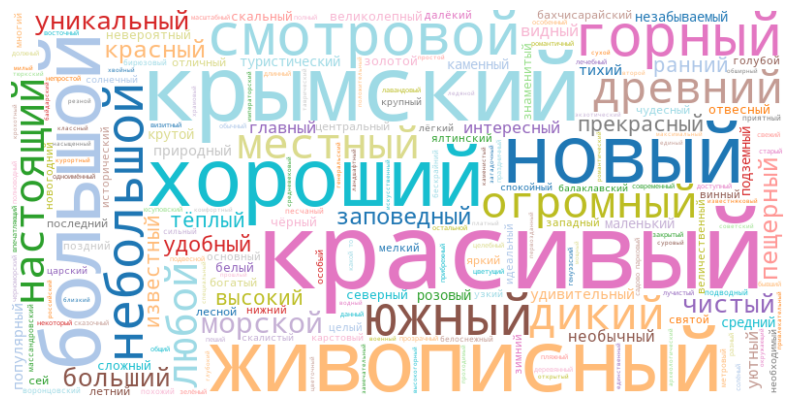

In [83]:
list_of_adj = [] 
for token in crim_text_no_stop.split(): 
    word_parsed = morph.parse(token)[0]
    if word_parsed.tag.POS == 'ADJF' or word_parsed.tag.POS == 'ADJS':
        list_of_adj.append(word_parsed.normal_form) 
only_adj = ' '.join(list_of_adj)

wordcloud = WordCloud(background_color='white', colormap = 'tab20', width=800, height=400, random_state=21, max_font_size=110).generate(only_adj)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [35]:
# Объединяем все тексты про Сахалин
sachalin_posts = df[df['Название региона'].str.contains('#сахалинскаяобласть', na=False)]

# Объединяем все тексты из отфильтрованных строк в одну строку
combined_text = ' '.join(sachalin_posts['Текст'].tolist())

# Сохраняем объединенный текст в файл
with open('Тексты_#сахалинскаяобласть.txt', 'w', encoding='utf-8') as f:
    f.write(combined_text)

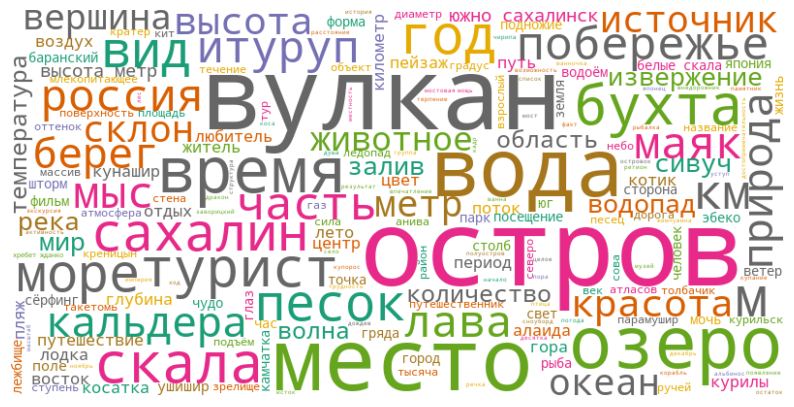

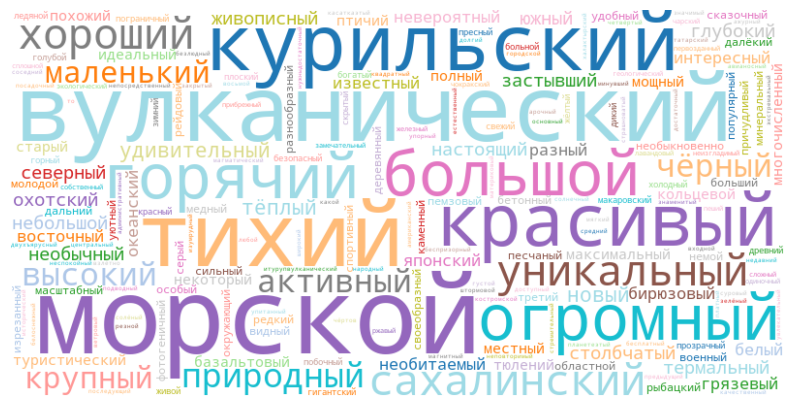

In [41]:
from nltk.corpus import stopwords
path = 'Тексты_#сахалинскаяобласть.txt'
with open(path, encoding='utf-8') as txt:
    sachalin_text = txt.read()
#print(text)
sachalin_text = re.sub('[^a-zA-Zа-яА-ЯёЁ -]', '', sachalin_text.lower()) # Удаляем лишние символы
sachalin_text = re.sub(r'\s+', ' ', sachalin_text).strip() # Удаляем лишние пробелы
#print(sachalin_text)
lemm_tokens1 = []
for token in word_tokenize(sachalin_text):
    token_lemma = morph.parse(token)[0].normal_form
    lemm_tokens1.append(token_lemma)
lemm_text_sachalin = ' '.join(lemm_tokens1)
#print(lemm_text_sachalin)
stopwords_ru = stopwords.words('russian')
stopwords = stopwords_ru + ['который', 'самый', 'каждый', 'свой','первый','такой','этот','сам','её','ваш','наш','весь']
tokens = lemm_text_sachalin.split()
sachalin_text_no_stop = ' '.join([token for token in tokens if token not in stopwords])
list_of_nouns1 = [] 
for token in sachalin_text_no_stop.split(): #будем проверять каждое слово отдельно по очереди
    word_parsed = morph.parse(token)[0]
    if word_parsed.tag.POS == 'NOUN': #проверяем существительные
        list_of_nouns1.append(word_parsed.normal_form) #сохраняем их в отдельный список
only_nouns1 = ' '.join(list_of_nouns1)
wordcloud = WordCloud(background_color='white', colormap = 'Dark2', width=800, height=400, random_state=21, max_font_size=110).generate(only_nouns1)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

list_of_adj1 = [] 
for token in sachalin_text_no_stop.split(): 
    word_parsed = morph.parse(token)[0]
    if word_parsed.tag.POS == 'ADJF' or word_parsed.tag.POS == 'ADJS':
        list_of_adj1.append(word_parsed.normal_form) 
only_adj1 = ' '.join(list_of_adj1)

wordcloud = WordCloud(background_color='white', colormap = 'tab20', width=800, height=400, random_state=21, max_font_size=110).generate(only_adj1)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

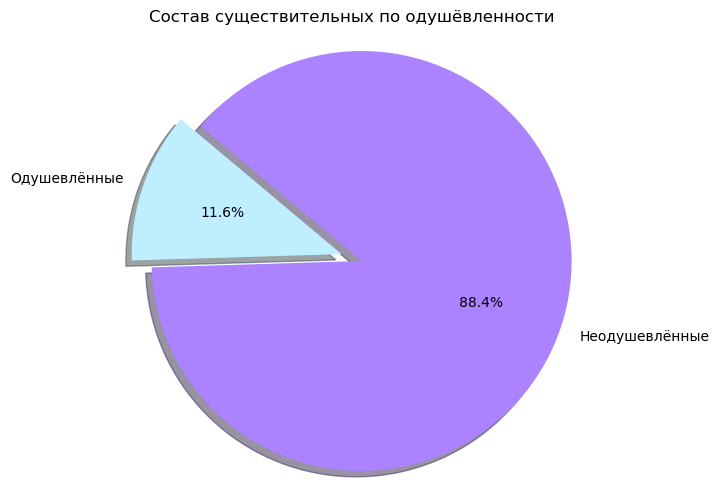

In [43]:
# Список для разделения существительных
animate_nouns = 0  # Одушевленные
inanimate_nouns = 0  # Неодушевленные

# Проверяем каждое слово
for token in sachalin_text_no_stop.split():
    word_parsed = morph.parse(token)[0]
    if word_parsed.tag.POS == 'NOUN':  # Проверяем существительные
        if word_parsed.tag.animacy == 'anim':  # Одушевленные
            animate_nouns += 1
        elif word_parsed.tag.animacy == 'inan':  # Неодушевленные
            inanimate_nouns += 1

# Данные для диаграммы
labels = ['Одушевлённые', 'Неодушевлённые']
sizes = [animate_nouns, inanimate_nouns]
colors = ['#BFEFFF','#AB82FF']
explode = (0.1, 0)  # "выделение" первого сегмента

# Создание круговой диаграммы
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Убедиться, что круг не будет эллипсом
plt.title('Состав существительных по одушёвленности')
plt.show()

In [45]:
animate_nouns

193

In [47]:
inanimate_nouns

1472

In [71]:
# Объединяем все тексты постов, опубликованных летом 2024
# Преобразуем столбец 'Дата публикации' в формат даты
df['Дата публикации'] = pd.to_datetime(df['Дата публикации'], errors='coerce')

# Фильтруем данные по заданным месяцам и году
filtered_posts = df[(df['Дата публикации'].dt.year == 2024) & 
                    (df['Дата публикации'].dt.month.isin([6, 7, 8]))]

# Убедимся, что данные отсортированы сначала по месяцу, затем по дате
filtered_posts = filtered_posts.sort_values(by='Дата публикации')

# Объединяем тексты постов в одну строку
combined_texts_leto24 = ' '.join(filtered_posts['Текст'].tolist())

# Выводим результат (проверяем правильно ли собрались тексты)
print(combined_texts_leto24[:1000])
print(combined_texts_leto24[-1000:])

с мыса Чикен-Кая. Сильно выдающийся в море скальный мыс Капчик с утра и до позднего вечера служит излюбленным местом променадов курортников из посёлка Новый Свет. Рядом расположен мыс Чикен-Кая также популярная локация среди гостей полуострова. Два мыса разделяет Голубая бухта. С мыса Чикен-Кая открывается великолепный вид на окрестности бухты. Его стоит посетить на самом рассвете вокруг ни души только море скалы сосны и первые тёплые лучи солнца на горизонте. Этот песчаный карьер появился лет назад. Когда оттуда начали вывозить песок пошла вода добычу свернули и образовался водоём. Сначала он был нежно-лазурного цвета потом там появились рыбки и водоросли и он начал зеленеть. Теперь озеро изумрудного цвета Калининградская обл. Мало кто знает что в Синявино скрывается уникальный пруд образовавшийся на месте бывшего янтарного карьера Вальтер. С по годы здесь добывали янтарь а после закрытия карьера пруд заполнился родниковыми и грунтовыми водами. Теперь это место привлекает дайверов сво

In [73]:
combined_texts_leto24 = re.sub('#', ' ', combined_texts_leto24)
combined_texts_leto24 = re.sub('[^a-zA-Zа-яА-ЯёЁ -]', ' ', combined_texts_leto24)  
texts_leto24 = re.sub(r'\s+', ' ', combined_texts_leto24).strip().lower() # Удаляем лишние пробелы
print(texts_leto24[:1000])

с мыса чикен-кая сильно выдающийся в море скальный мыс капчик с утра и до позднего вечера служит излюбленным местом променадов курортников из посёлка новый свет рядом расположен мыс чикен-кая также популярная локация среди гостей полуострова два мыса разделяет голубая бухта с мыса чикен-кая открывается великолепный вид на окрестности бухты его стоит посетить на самом рассвете вокруг ни души только море скалы сосны и первые тёплые лучи солнца на горизонте этот песчаный карьер появился лет назад когда оттуда начали вывозить песок пошла вода добычу свернули и образовался водоём сначала он был нежно-лазурного цвета потом там появились рыбки и водоросли и он начал зеленеть теперь озеро изумрудного цвета калининградская обл мало кто знает что в синявино скрывается уникальный пруд образовавшийся на месте бывшего янтарного карьера вальтер с по годы здесь добывали янтарь а после закрытия карьера пруд заполнился родниковыми и грунтовыми водами теперь это место привлекает дайверов своей кристальн

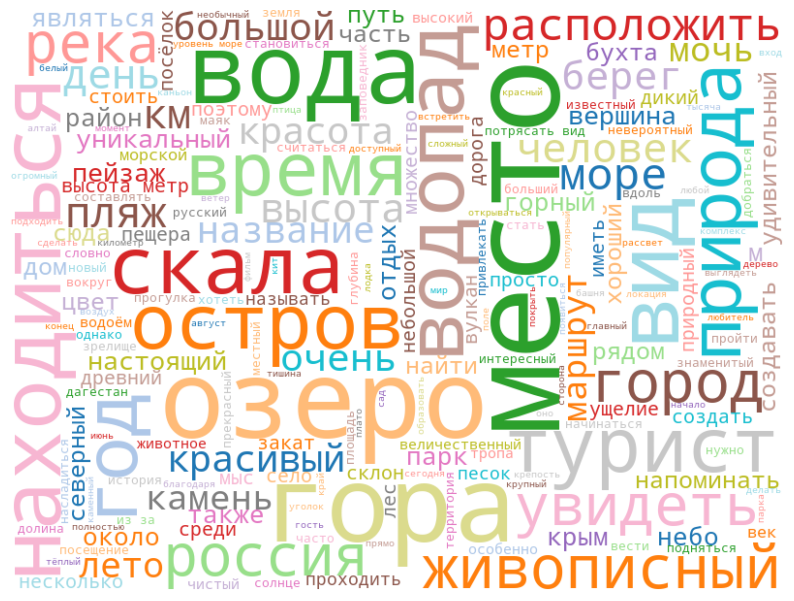

In [95]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
lemm_tokens2 = []
for token in word_tokenize(texts_leto24):
    token_lemma = morph.parse(token)[0].normal_form
    lemm_tokens2.append(token_lemma)
lemm_text_leto24 = ' '.join(lemm_tokens2)
#print(lemm_text_leto24)
stopwords_ru = stopwords.words('russian')
stopwords = stopwords_ru + ['который', 'самый', 'каждый', 'свой','первый','такой','этот','сам','её','ваш','наш','весь','это','всё', 'ещё']
tokens = lemm_text_leto24.split()
leto24_text_no_stop = ' '.join([token for token in tokens if token not in stopwords])
#print(leto24_text_no_stop)
wordcloud = WordCloud(background_color='white', colormap = 'tab20', width=800, height=600, random_state=22, max_font_size=130).generate(leto24_text_no_stop)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [129]:
print(len(leto24_text_no_stop))

131876


In [ ]:
list_of_nouns2 = [] 
for token in leto24_text_no_stop.split(): #будем проверять каждое слово отдельно по очереди
    word_parsed = morph.parse(token)[0]
    if word_parsed.tag.POS == 'NOUN': #проверяем существительные
        list_of_nouns2.append(word_parsed.normal_form) #сохраняем их в отдельный список
only_nouns2 = ' '.join(list_of_nouns2)
wordcloud = WordCloud(background_color='white', colormap = 'Dark2', width=800, height=400, random_state=21, max_font_size=110).generate(only_nouns2)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
list_of_adj2 = [] 
for token in leto24_text_no_stop.split(): 
    word_parsed = morph.parse(token)[0]
    if word_parsed.tag.POS == 'ADJF' or word_parsed.tag.POS == 'ADJS':
        list_of_adj2.append(word_parsed.normal_form) 
only_adj2 = ' '.join(list_of_adj2)

wordcloud = WordCloud(background_color='white', colormap = 'tab20', width=800, height=400, random_state=21, max_font_size=110).generate(only_adj2)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<Axes: title={'center': '20 самых частотных слов Лето-2024'}, xlabel='Samples', ylabel='Counts'>

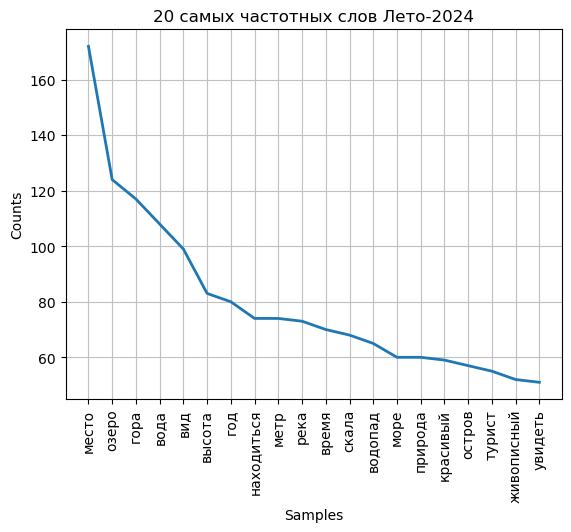

In [97]:
text_tokens_texts_leto24 = word_tokenize(leto24_text_no_stop)
word_frequencies = FreqDist(text_tokens_texts_leto24)
#print(dict(sorted(word_frequencies.items(), key=lambda item: item[1], reverse=True)))
word_frequencies.plot(20, title='20 самых частотных слов Лето-2024')

<Axes: title={'center': '20 самых частотных слов Лето-2023'}, xlabel='Samples', ylabel='Counts'>

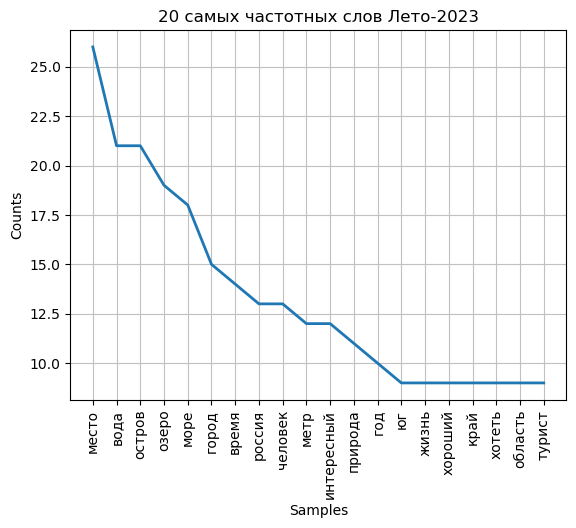

In [123]:
from nltk.probability import FreqDist
# Объединяем все тексты постов, опубликованных летом 2023
# Преобразуем столбец 'Дата публикации' в формат даты
df['Дата публикации'] = pd.to_datetime(df['Дата публикации'], errors='coerce')

# Фильтруем данные по заданным месяцам и году
filtered_posts = df[(df['Дата публикации'].dt.year == 2023) & 
                    (df['Дата публикации'].dt.month.isin([6, 7, 8]))]

# Убедимся, что данные отсортированы сначала по месяцу, затем по дате
filtered_posts = filtered_posts.sort_values(by='Дата публикации')

# Объединяем тексты постов в одну строку
combined_texts_leto23 = ' '.join(filtered_posts['Текст'].tolist())
#print(combined_texts_leto23)
combined_texts_leto23 = re.sub('#', ' ', combined_texts_leto23)
combined_texts_leto23 = re.sub('[^a-zA-Zа-яА-ЯёЁ -]', ' ', combined_texts_leto23)  
texts_leto23 = re.sub(r'\s+', ' ', combined_texts_leto23).strip().lower() # Удаляем лишние пробелы
#print(texts_leto23)
from nltk.corpus import stopwords
lemm_tokens3 = []
for token in word_tokenize(texts_leto23):
    token_lemma = morph.parse(token)[0].normal_form
    lemm_tokens3.append(token_lemma)
lemm_text_leto23 = ' '.join(lemm_tokens3)
#print(lemm_text_leto24)
stopwords_ru = stopwords.words('russian')
stopwords = stopwords_ru + ['который', 'самый', 'каждый', 'свой','первый','такой','этот','сам','её','ваш','наш','весь','это','всё', 'ещё','очень', 'около', 'м', 'км', 'c', 'г']
tokens = lemm_text_leto23.split()
leto23_text_no_stop = ' '.join([token for token in tokens if token not in stopwords])
#print(leto23_text_no_stop)
text_tokens_texts_leto23 = word_tokenize(leto23_text_no_stop)
word_frequencies = FreqDist(text_tokens_texts_leto23)
#print(dict(sorted(word_frequencies.items(), key=lambda item: item[1], reverse=True)))
word_frequencies.plot(20, title='20 самых частотных слов Лето-2023')



In [127]:
print(len(leto23_text_no_stop))

21615


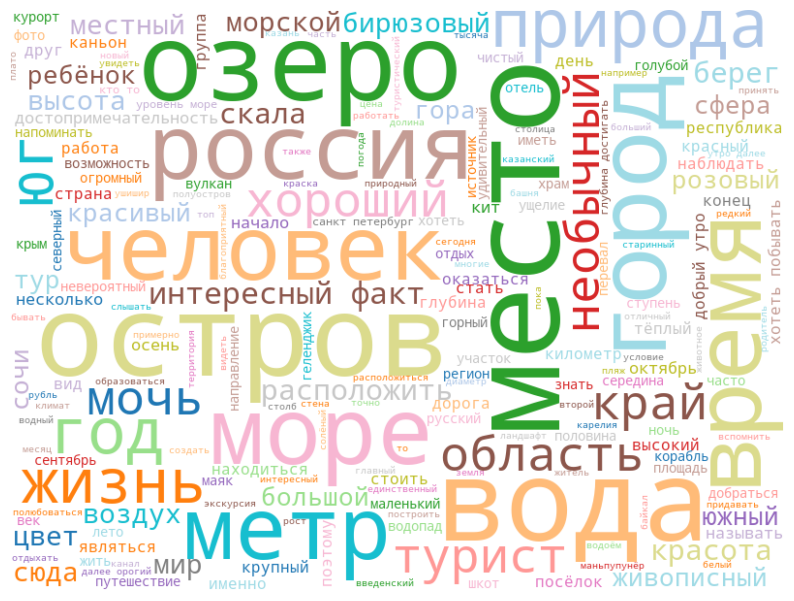

In [125]:
wordcloud = WordCloud(background_color='white', colormap = 'tab20', width=800, height=600, random_state=22, max_font_size=130).generate(leto23_text_no_stop)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<Axes: title={'center': '20 самых частотных слов Зима-2024'}, xlabel='Samples', ylabel='Counts'>

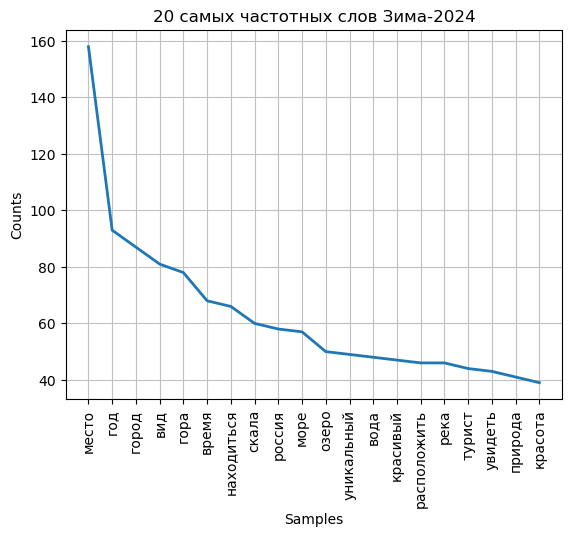

In [173]:
####
#### ПРОДЕЛЫВАЕМ ТЕ ЖЕ ДЕЙСТВИЯ С ТЕКСТАМИ ЗА ЗИМНИЙ ПЕРИОД:
####

df['Дата публикации'] = pd.to_datetime(df['Дата публикации'], errors='coerce')

# Фильтруем данные по заданным месяцам и годам
filtered_posts = df[((df['Дата публикации'].dt.year == 2023) & (df['Дата публикации'].dt.month == 12)) | 
                    ((df['Дата публикации'].dt.year == 2024) & (df['Дата публикации'].dt.month.isin([1, 2])))]

# Убедимся, что данные отсортированы сначала по дате
filtered_posts = filtered_posts.sort_values(by='Дата публикации')

# Объединяем тексты постов в одну строку
combined_texts_zima24 = ' '.join(filtered_posts['Текст'].tolist())
#print(combined_texts_leto23)
combined_texts_zima24 = re.sub('#', ' ', combined_texts_zima24)
combined_texts_zima24 = re.sub('[^a-zA-Zа-яА-ЯёЁ -]', ' ', combined_texts_zima24)  
texts_zima24 = re.sub(r'\s+', ' ', combined_texts_zima24).strip().lower() # Удаляем лишние пробелы
#print(texts_leto23)
from nltk.corpus import stopwords
lemm_tokens4 = []
for token in word_tokenize(texts_zima24):
    token_lemma = morph.parse(token)[0].normal_form
    lemm_tokens4.append(token_lemma)
lemm_text_zima24 = ' '.join(lemm_tokens4)
#print(lemm_text_leto24)
stopwords_ru = stopwords.words('russian')
stopwords = stopwords_ru + ['который', 'самый', 'каждый', 'свой','первый','такой','этот','сам','её','ваш','наш','весь','это','всё', 'ещё','очень', 'около', 'м', 'км', 'c', 'г']
tokens = lemm_text_zima24.split()
zima24_text_no_stop = ' '.join([token for token in tokens if token not in stopwords])

text_tokens_texts_zima24 = word_tokenize(zima24_text_no_stop)
word_frequencies = FreqDist(text_tokens_texts_zima24)
#print(dict(sorted(word_frequencies.items(), key=lambda item: item[1], reverse=True)))
word_frequencies.plot(20, title='20 самых частотных слов Зима-2024')


In [177]:
print(len(zima24_text_no_stop))

118881


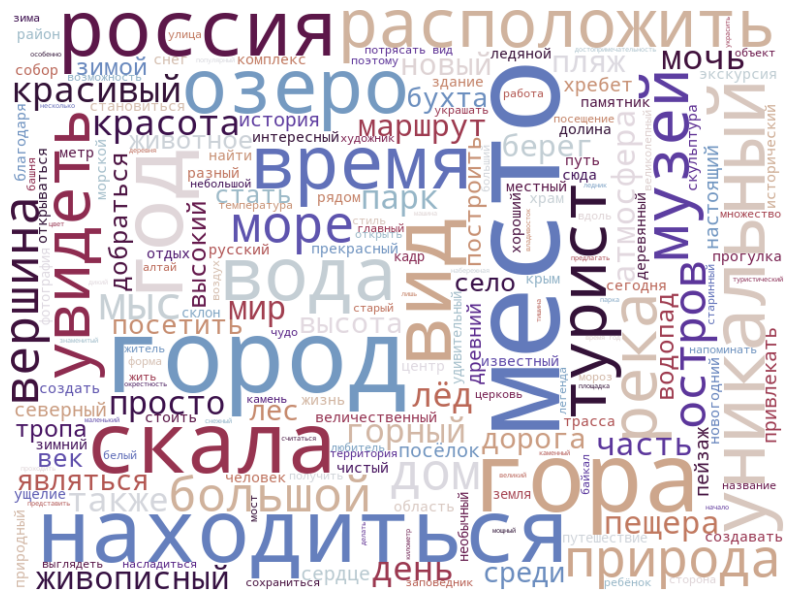

In [175]:
wordcloud = WordCloud(background_color='white', colormap = 'twilight', width=800, height=600, random_state=22, max_font_size=130).generate(zima24_text_no_stop)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [57]:
import itertools
from collections import Counter, defaultdict
import numpy as np
import re
from string import punctuation
from nltk.corpus import stopwords
from pymorphy3 import MorphAnalyzer
morph = MorphAnalyzer()
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.collocations import *

In [59]:
from nltk.corpus import stopwords
stops = set(stopwords.words('russian') + ['который', 'самый', 'каждый', 'свой','первый','такой','этот','сам','её','ваш','наш','весь','это','всё', 'ещё','очень']) 

def normalize(text):
    normalized_text = [morph.parse(token)[0].normal_form for token in word_tokenize(text.lower()) if len(token) > 2 and token not in stops]  
    return normalized_text

def ngrammer(tokens, n=2):
    ngrams = []
    tokens_cl = [token for token in word_tokenize(tokens.lower()) if token not in stops]
    for i in range(0, len(tokens_cl)-n+1):
        ngrams.append(tuple(tokens_cl[i:i+n]))
    return ngrams


In [61]:
path = 'C:\\Users\\Алексей\\общий_текст.txt'
with open(path, encoding='utf-8') as txt:
    corpus = txt.read()
    corpus = re.sub(r'\n', '', corpus)
    corpus = re.sub(r'[a-zA-Z…]',  '', corpus)
    
    corpus_sent = sent_tokenize(corpus) #разбиение на предложения
    corpus_sent_clean = [] #cюда мы сохраняем чистые предложения
    for sent in corpus_sent: #пройдемся по каждому предложению
        corpus_sent_clean.append(' '.join(normalize(sent))) #предобработаем

In [63]:
corpus_sent_clean[100:105]

['единственный городской ворота калининград сей пора использоваться прямой назначениюсквозить проходить дорога',
 'построить кёнигсберг дорога ведущий замок бранденбург посёлок ушаковый',
 'означать туризм драйвер экономика регион',
 'заявить министр экономический развитие максим решетник рамка рабочий поездка край',
 'салтинский водопад единственный дагестан подземный водопад свято-введенский женский пустынь покров западный окраина владимирский область относиться редкий средний полоса россия островной монастырь']

In [65]:
word_counter = Counter()

for sent in corpus_sent_clean:
    word_counter.update(ngrammer(sent, n=2))
word_counter.most_common(10)

[(('высота', 'метр'), 111),
 (('время', 'год'), 73),
 (('смотровой', 'площадка'), 73),
 (('потрясать', 'вид'), 72),
 (('уровень', 'море'), 58),
 (('местный', 'житель'), 55),
 (('красивый', 'место'), 50),
 (('год', 'назад'), 47),
 (('любой', 'время'), 44),
 (('сей', 'пора'), 42)]

In [67]:
corpus = ' '.join(corpus_sent_clean)
text = corpus
tagged_tuples = ['_'.join((str(morph.parse(token)[0].normal_form), str(morph.parse(token)[0].tag.POS))) for token in word_tokenize(text)]
tagged_text = ' '.join(tagged_tuples)
tagged_text[:1000]

'строительный_ADJF сфера_NOUN юг_NOUN развиваться_INFN семимильный_ADJF шаг_NOUN спец_NOUN какой-либо_ADJF строительный_ADJF сфера_NOUN работа_NOUN архитектура_NOUN дизайн_NOUN интерьер_NOUN ландшафтный_ADJF дизайн_NOUN агенство_NOUN недвижимость_NOUN юг_NOUN комиссия_NOUN платить_INFN покупатель_NOUN продавец_NOUN строить_INFN иллюзия_NOUN опыт_NOUN вероятный_ADJF продажа_NOUN поэтому_ADVB нужно_PRED постоянно_ADVB проходить_INFN различный_ADJF обучение_NOUN направление_NOUN знать_INFN город_NOUN сфера_NOUN отель_NOUN санаторий_NOUN соответственно_ADVB вакансия_NOUN направление_NOUN предостаточно_ADVB общепит_NOUN ресторан_NOUN кафе_NOUN барыосновный_ADJF заработок_NOUN лето_NOUN заведение_NOUN один_ADJF топовый_ADJF местный_ADJF житель_NOUN любить_INFN частенько_ADVB походить_INFN заведение_NOUN фриланс_NOUN россиикраснодар_NOUN сочи_NOUN столица_NOUN фрилансер_NOUN медицинский_ADJF сфера_NOUN сфера_NOUN образование_NOUN частный_ADJF школа_NOUN детский_ADJF сад_NOUN переполнить_INFN 

In [69]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder_big = BigramCollocationFinder.from_words(word_tokenize(tagged_text))
scores_student_t = finder_big.score_ngrams(bigram_measures.student_t)

In [71]:
bigrams_with_nouns = []
for bigram_measured in scores_student_t:
    if re.match(r'\w+_ADJ', bigram_measured[0][0]) and re.match(r'\w+_NOUN', bigram_measured[0][1]):
        bigrams_with_nouns.append(bigram_measured)
print(bigrams_with_nouns[:10])

[(('смотровой_ADJF', 'площадка_NOUN'), 8.52902576369029), (('местный_ADJF', 'житель_NOUN'), 7.386025856715169), (('красивый_ADJF', 'место_NOUN'), 6.552357441536404), (('сей_ADJF', 'пора_NOUN'), 6.475611737973314), (('любой_ADJF', 'время_NOUN'), 6.316939911680961), (('краснодарский_ADJF', 'край_NOUN'), 5.988889401843559), (('приморский_ADJF', 'край_NOUN'), 5.8165105754556174), (('живописный_ADJF', 'место_NOUN'), 5.585360786667283), (('активный_ADJF', 'отдых_NOUN'), 5.548867706012746), (('этот_ADJF', 'место_NOUN'), 5.45319738238884)]


In [75]:
# Создаем списки для словосочетаний и метрик
phrases = []
metrics = []

for bigram in bigrams_with_nouns:
    # Извлекаем прилагательное и существительное и добавляем их в phrases
    adjective = bigram[0][0].split('_')[0]  # Удаляем часть речи
    noun = bigram[0][1].split('_')[0]  # Удаляем часть речи
    phrases.append(f"{adjective} {noun}")  # Формируем словосочетание

    # Добавляем метрику во второй список
    metrics.append(bigram[1])  # Предполагаем, что метрика находится во втором элементе

# Создаем датафрейм
df_bigrams = pd.DataFrame({
    'Биграммы': phrases,
    'Рейтинг': metrics
})

# Выводим DataFrame
df_bigrams.head(20)

,Биграммы,Рейтинг
0,смотровой площадка,8.529026
1,местный житель,7.386026
2,красивый место,6.552357
3,сей пора,6.475612
4,любой время,6.316940
5,краснодарский край,5.988889
6,приморский край,5.816511
7,живописный место,5.585361
8,активный отдых,5.548868
9,этот место,5.453197


In [273]:
df_bigrams.iloc[39:144]

,Биграммы,Рейтинг
39,северный сияние,4.229311
40,национальный парк,4.223838
41,красивый вид,4.180503
42,дикий природа,4.177696
43,природный красота,4.141892
...,...,...
139,хвойный лес,2.991690
140,баренцев море,2.990194
141,туристический инфраструктура,2.988726
142,балтийский море,2.985836


In [279]:
# Найдём пост, который собрал больше всего реакций
# Преобразуем словарное представление эмодзи в DataFrame
df['Общее количество эмодзи'] = df['Эмодзи'].apply(lambda x: sum(x.values()))

# Находим индекс поста с максимальным количеством эмодзи
max_emoji_index = df['Общее количество эмодзи'].idxmax()

# Получаем текст поста с максимальным количеством эмодзи
post_with_max_emojis = df.loc[max_emoji_index, 'Текст']

#print(f"Текст поста с максимальным количеством эмодзи:\n{post_with_max_emojis}")
post_with_max_emojis

'Такую инициативу выдвинул политик Борис Чернышов заявив что это создаёт звуковой и визуальный шум и что нужно думать об удобстве россиян в первую очередь. Чиновник отметил что перед путешествием в другую страну человек должен позаботиться о том чтобы владеть минимальными навыками общения на местном языке. Как Вам такая инициатива? Да Нет Загранник Необычные Путешествия'

In [283]:
df.loc[max_emoji_index]

Заголовок                  В Госдуме предложили запретить объявления на а...
Текст                      Такую инициативу выдвинул политик Борис Черныш...
Дата публикации                                08.09.2023 23:22:23 UTC+04:00
Эмодзи                     {'👍': 1664, '👎': 1209, '🤔': 52, '🤡': 43, '🔥': ...
Локация на карте                                                            
Название региона                                                            
Общее количество эмодзи                                                 2999
Name: 144, dtype: object